# Practica: Redes convolucionales

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]

import numpy as np

In [18]:
#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST

#Definimos el dispositivo que se usara.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

#device = "cpu"

Device:  cuda


In [19]:
def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size) 

# Cifar 10
Es un conjunto de datos que tiene 60,000 imagenes de 32x32 a color de 10 clases distintas (cada clase con 6,000 elementos).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Podemos descargar CIFAR-10 con el modulo de torchvision.

In [20]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Para resolver el problema de clasificación de las imágenes de CIFAR-10 usaremos una red neuronal 
cuya arquitectura sea la siguiente:

* Una capa convolucional de entrada con un filtro de (5,5) y 64 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Otra capa convolucional con un filtro de (5,5) y 32 filtros de salida con activación ReLu
* Una capa de MaxPooling de (3,3)
* Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
* Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
* Finalmente,una capa de salida con 10 neuronas



In [21]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
import torch.nn.functional as F
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''
        Construccion de la Red, define las capas que se utiizaran.
        '''
        super(CIFAR_NET, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

        # Conectamos las capas 
        self.fc1 = nn.Linear(32 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 10)  # 10 clases en CIFAR-10


    def forward(self, x):
        '''
        Define el orden con el que se realizara la propagacion hacia adelante
        de la red.
        '''
        # Capa convolucional 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        # Capa convolucional 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Capa conectada 1
        x = x.view(-1, 32 * 5 * 5) # Aplanamos el tensor de la salida de la capa convolucional
        x = F.relu(self.fc1(x))

        # Capa conectada 2
        x = F.relu(self.fc2(x))

        # Capa conectada 3
        x = self.fc3(x)

        return x
    

    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''
        Define una funcion de entrenamiento, ten en cuenta la forma en la que llegan 
        los datos de data_loader, e itera sobre ellos. Realiza tambien el caso 
        en que se llegue a utilizar cuda. Muestra una grafica al finalizar el
        entrenamiento usando el lost obtenido.
        '''
        # Lista para almacenar las perdidas durante el entrenamiento
        losses = []

        # Si tenemos disponible una GPU, movemos la red a la GPU
        if(cuda and torch.cuda.is_available()):
            self.cuda()
        
        # Iteramos sobre el numero de epocas
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0):
                # Obtenemos los datos y los movemos a la GPU si es necesario
                inputs, labels = data
                if(cuda and torch.cuda.is_available()):
                    inputs, labels = inputs.cuda(), labels.cuda()

                # Reseteamos los gradientes
                optimizer.zero_grad()

                # Propagacion hacia adelante
                outputs = self(inputs)
                loss = criterion(outputs, labels)

                # Propagacion hacia atras y optimizacion
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                # Imprimimos estadisticas
                '''
                if i % 2000 == 1999:  
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
                '''
                '''
                if i % 2000 == 1999:    # Imprimimos cada 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    losses.append(running_loss)
                    running_loss = 0.0
                '''

            # Guardamos la perdida promedio del epoch
            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print('Epoch %d, loss: %.3f' % (epoch + 1, epoch_loss))
        
        # Graficamos las perdidas
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Perdida durante el entrenamiento')
        plt.show()
        


Epoch 1, loss: 1.614
Epoch 2, loss: 1.311
Epoch 3, loss: 1.168
Epoch 4, loss: 1.065
Epoch 5, loss: 0.980
Epoch 6, loss: 0.902
Epoch 7, loss: 0.832
Epoch 8, loss: 0.768
Epoch 9, loss: 0.706
Epoch 10, loss: 0.655
Epoch 11, loss: 0.599
Epoch 12, loss: 0.550
Epoch 13, loss: 0.500
Epoch 14, loss: 0.455
Epoch 15, loss: 0.408
Epoch 16, loss: 0.366
Epoch 17, loss: 0.324
Epoch 18, loss: 0.285
Epoch 19, loss: 0.256
Epoch 20, loss: 0.223
Epoch 21, loss: 0.196
Epoch 22, loss: 0.172
Epoch 23, loss: 0.152
Epoch 24, loss: 0.138
Epoch 25, loss: 0.123
Epoch 26, loss: 0.111
Epoch 27, loss: 0.107
Epoch 28, loss: 0.096
Epoch 29, loss: 0.091
Epoch 30, loss: 0.086


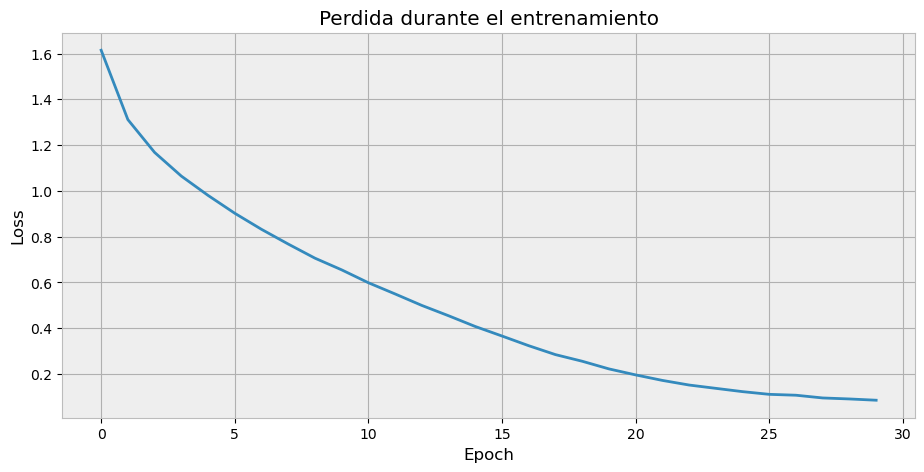

In [26]:
import torch.optim as optim

RedCIFAR=CIFAR_NET()

# Definimos el criterio de perdida (entropia cruzada) y el optimizador (Adam)
criterio = nn.CrossEntropyLoss()
optimizer = optim.Adam(RedCIFAR.parameters(), lr=0.0001)

# Preprocesamiento necesario si se va a usar CUDA (GPU)
cuda = True  
if cuda and torch.cuda.is_available(): # Cambia a False si no tenemos una GPU disponible
    RedCIFAR.cuda()

#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(30,trainloader,criterio,optimizer,cuda=cuda) 

In [27]:
# prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
prec_train = calcularPrecisionGlobal(RedCIFAR, trainloader, 4, cuda=cuda)

# prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
prec_val = calcularPrecisionGlobal(RedCIFAR, testloader, 4, cuda=cuda)


# print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train),cuda=cuda)
print("Precision en conjunto de entrenamiento: %.4f%%" % prec_train)

#print("Precision en conjunto de validacion: %.4f%%"%(prec_val),cuda=cuda)
print("Precision en conjunto de validacion: %.4f%%" % prec_val)

Precision en conjunto de entrenamiento: 95.2180%
Precision en conjunto de validacion: 67.1200%


## Ejercicios:
* Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve. Muestra la imagen con la que se está alimentando a la red.
* Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles. Para ello en lugar de tener en cuenta únicamente los valores de verdaderos positivos, verdaderos negativos, etc, se usarán los 10 elementos, por lo que debemos tener en cuenta cuantos de cada categoria fueron clasificados incorrectamente, y en cual fue.
* Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.

Referencias:

* Krizhevsky , Nair , Hinton. CIFAR-10. https://www.cs.toronto.edu/~kriz/cifar.html
* Pytorch, TORCH.NN, https://pytorch.org/docs/stable/nn.html
* Goodfellow-et-al. (2016). Deep Learning. MIT Press. https://www.deeplearningbook.org/contents/convnets.html

In [28]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()